# Clinical Trial Optimization 

Je presente ici ma solution pour le probléme d'opimisation d'un trie de sujet pour un test clinique.

### Presentation du probléme

Cette compétition organisée par Ingenii portait sur l'optimisation du tri des sujets pour un essai clinique. La description complète du problème est disponible sur [la plateforme Aqora](https://aqora.io/competitions/ingenii-clinical-trial), qui héberge la compétition.

Le problème consiste à regrouper les sujets en fonction de certains paramètres lors d'un essai clinique. L'objectif est qu'à l'issue de la formation des groupes, les sujets d'un même groupe soient adaptés aux tests cliniques qu'ils devront subir.

### Formulation mathématique

Nous avons 100 sujets que nous souhaitons répartir en deux groupes $p = \{1, 2\}$ de 50 personnes chacun. Chaque sujet $i$ est caractérisé par 3 paramètres $\vec{w_i} = (w_{i1}, w_{i2}, w_{i3})$. Nous mesurons la qualité de ce partitionnement à l'aide de la grandeur suivante :

$$
d = \sum_{s=1}^{3} |\Delta\mu_s| + \rho \sum_{s=1}^{3} |\Delta\sigma_{ss}| + 2\rho \sum_{s=1}^{3} \sum_{s' = s+1}^{3} |\Delta\sigma_{ss'}|
$$

où :

$$
\Delta\mu_s = \frac{1}{n} \sum_{i=1}^{n} w_{is}(x_{i1} - x_{i2})
$$

et :

$$
\Delta\sigma_{ss'} = \frac{1}{n} \sum_{i=1}^{n} w_{is} w_{is'} (x_{i1} - x_{i2})
$$

$x_{ip}$ est une variable binaire qui vaut 1 si le sujet $i$ appartient au groupe $p$, et 0 sinon.

La grandeur $d$ est appelée la *discrepancy*. Pour un regroupement idéal, la *discrepancy* est minimale. Ce problème de regroupement se ramène donc à résoudre le problème d'optimisation suivant :

$$
\min_{x} d
$$

sous les contraintes :

$$
\sum_{i}x_{ip} = \frac{n}{2}, \quad \text{Chaque groupe contient le même nombre de sujets.}
$$

$$
x_{i1} + x_{i2} = 1, \quad \text{Un sujet ne peut appartenir qu'à un seul groupe après le regroupement.}
$$

$$
x_{12} = 0, \quad \text{Ceci pour éviter la redondance des solutions, car on obtient le même regroupement en intervertissant les groupes 1 et 2.}
$$

### Reformulation du problème

Dans sa formulation initiale, le problème semble nous orienter vers l'utilisation de l'algorithme QAOA. Cependant, cette formulation ne permet pas une implémentation directe de l'algorithme en raison de la présence de valeurs absolues dans la fonction objective. De plus, le nombre de variables impliquées est très élevé : on a effectivement $2n-1$ variables, soit 199 variables dans ce cas, ce qui nécessiterait au moins une machine de 199 qubits, ce qui n'est actuellement pas disponible.

* **Écriture sans valeurs absolues :**
$$ a = |x| \Rightarrow x \leq a \text{ et } -x \leq a$$

Nous posons alors $z_s = |\Delta\mu_s|$, $z_{ss} = |\Delta\sigma_{ss}|$, et $z_{ss'} = |\Delta\sigma_{ss'}|$. La nouvelle formulation devient :
$$
\min_{x, z} \sum_{s=1}^{3} z_s + \rho \sum_{s=1}^{3} z_{ss} + 2\rho \sum_{s=1}^{3} \sum_{s' = s+1}^{3} z_{ss'}
$$
sous les contraintes suivantes :
$$
\sum_{i} x_{ip} = \frac{n}{2}, \quad \text{chaque groupe contient le même nombre de sujets.}
$$
$$
x_{i1} + x_{i2} = 1, \quad \text{un sujet ne peut appartenir qu'à un seul groupe après le regroupement.}
$$
$$
x_{12} = 0, \quad \text{cela évite la redondance des solutions, car intervertir les groupes 1 et 2 donnerait le même regroupement.}
$$
$$
\Delta\mu_s \leq z_s \text{ et } -\Delta\mu_s \leq z_s
$$
$$
\Delta\sigma_{ss} \leq z_{ss} \text{ et } -\Delta\sigma_{ss} \leq z_{ss}
$$
$$
\Delta\sigma_{ss'} \leq z_{ss'} \text{ et } -\Delta\sigma_{ss'} \leq z_{ss'}
$$

* **Réduction du nombre de variables :**

En remplaçant la contrainte $x_{i1} + x_{i2} = 1$ dans le problème, nous réduisons de $n$ le nombre de variables. En ajoutant les variables $z$, nous obtenons finalement $n - 1 + 9$, soit $n + 8$ variables.

# Implémentation
À ce stade, le problème est bien défini pour être implémenté avec l'algorithme QAOA. La prochaine étape consiste à le transformer en un problème QUBO, une transformation bien connue et générique. Cette étape sera réalisée à l'aide d'une bibliothèque dédiée de Qiskit.

In [212]:
from qiskit_optimization import QuadraticProgram

In [213]:
n =  100 #number of subjects
N = 1 # on enléve la division par 1 dans la fonction objective
rho = 0.5

In [214]:
import csv
import numpy as np

data_list_csv = []
with open('pbc.csv', mode='r') as file:
    reader = csv.reader(file)
    # Skip the header
    next(reader)
    # Iterate over the rows and add them to the list
    for row in reader:
        # Convert strings to float for numeric columns
        data_list_csv.append([float(row[0]), float(row[1]), float(row[2])])

max_values = np.max(data_list_csv , axis=0)
data_list_frmt = data_list_csv




In [215]:
print(data_list_frmt[:10])

[[12.2, 58.7652292950034, 1718.0], [10.6, 56.4462696783025, 7394.8], [12.0, 70.072553045859, 516.0], [10.3, 54.7405886379192, 6121.8], [10.9, 38.1054072553046, 671.0], [11.0, 66.258726899384, 944.0], [9.7, 55.5345653661875, 824.0], [11.0, 53.056810403833, 4651.2], [11.0, 42.507871321013, 2276.0], [11.5, 70.5598904859685, 918.0]]


In [216]:
mod = QuadraticProgram("Clinical trial Optimization")

for i in range(1 , n + 1):
    var_name = f"x_{i}1"
    mod.binary_var(name=var_name)

# Variables entiere   
W = []
for i in range(3):
    w_list = [row[i] for row in data_list_frmt]
    w_sum = 0
    for w in w_list:
        w_sum = w_sum + w # Somme des w
    W.append(w_sum)

mod.integer_var(name= "z_1" , lowerbound=0 , upperbound= int(W[0]) + 1)
mod.integer_var(name= "z_2" , lowerbound=0 , upperbound= int(W[1]) + 1)
mod.integer_var(name= "z_3" , lowerbound=0 , upperbound= int(W[2]) + 1)


W_square = []
for i in range(3):
    w_list = [row[i] for row in data_list_frmt]
    w_sum = 0
    for w in w_list:
        w_sum = w_sum + w**2 # somme des w au carré
    W_square.append(w_sum)

mod.integer_var(name= "z_11" , lowerbound=0 , upperbound= int(W_square[0]) + 1)
mod.integer_var(name= "z_22" , lowerbound=0 , upperbound= int(W_square[1]) + 1)
mod.integer_var(name= "z_33" , lowerbound=0 , upperbound= int(W_square[2]) + 1)


W_cross = []
for i in range(3):
    w_list_s = [row[i] for row in data_list_frmt]
    for k in range(i + 1, 3):
        w_sum = 0
        w_list_s_prime = [row[k] for row in data_list_frmt]
        for w_i, w_k in zip(w_list_s, w_list_s_prime):  
            w_sum = w_sum + w_i * w_k # somme des produit croisé de w
        W_cross.append(w_sum)
mod.integer_var(name = "z_12" , lowerbound=0 , upperbound=int(W_cross[0] + 1))
mod.integer_var(name = "z_13" , lowerbound=0 , upperbound=int(W_cross[1] + 1))
mod.integer_var(name = "z_23" , lowerbound=0 , upperbound=int(W_cross[2] + 1))




<Variable: 0 <= z_23 <= 30608403 (integer)>

In [217]:
# definition de la fonction objective
mod.minimize(linear={"z_1": 1 ,"z_2": 1 , "z_3": 1 
                      , "z_11":0.5 , "z_22":0.5 , "z_33":0.5
                      , "z_12":1 , "z_13":1 , "z_23":1})

# Les contraintes

Contraite $ \sum_{i} x_{ip} = \frac{n}{2} \text{ avec } p = 1$

In [218]:
dict_som = {f"x_{i}1": 1 for i in range(1 , n + 1)}
mod.linear_constraint(dict_som , sense= "==" , rhs = n/2 , name = "repartition egale")

<LinearConstraint: x_1001 + x_101 + x_11 + x_111 + x_121 + x_131 + x_... == 50.0 'repartition egale'>

Contrainte: $x_{12} = 0 \Rightarrow x_{11} = 1$

In [219]:
mod.linear_constraint({"x_11": 1} , sense= "==" , rhs = 1 , name= "avoid redundance")

<LinearConstraint: x_11 == 1 'avoid redundance'>

Contrainte: $\Delta\mu_s \leq z_s \text{ et } -\Delta\mu_s \leq z_s$

$$
\Delta\mu_s \leq z_s  \Rightarrow \sum_{i = 1}^{n}2w_{is}x_{i1} - nz_{s} \leq \sum_{i = 1}^{n}w_{is} \\

-\Delta\mu_s \leq z_s \Rightarrow \sum_{i = 1}^{n}2w_{is}x_{i1} + nz_{s} \geq \sum_{i = 1}^{n}w_{is} 
$$



In [220]:
for i in range(3):
    dict_x_s = {}
    w_list = [row[i] for row in data_list_frmt]

    # multipli toute l'équation par 100 pour avoir uniquement des coéfficients entiers
    dict_x_s = {f"x_{j + 1}1": int(round(2*w_list[j] , 2)*100)  for j in range(0 , n)} 
    dict_x_s.update({f"z_{i + 1}": -n * 100})
    mod.linear_constraint(linear=dict_x_s , sense= "<=" , rhs= int(round(W[i] , 2)*100))
    


for i in range(3):
    dict_x_s = {}
    w_list = [row[i] for row in data_list_frmt]
    dict_x_s = {f"x_{j + 1}1": int(round(2*w_list[j])*100)  for j in range(0 , n)}
    dict_x_s.update({f"z_{i + 1}": n*100})
    mod.linear_constraint(linear=dict_x_s , sense= ">=" , rhs= int(round(W[i] , 2)*100))
    

Contrainte: $\Delta\sigma_{ss} \leq z_{ss} \text{ et } -\Delta\sigma_{ss} \leq z_{ss}$

$$
\Delta\sigma_{ss} \leq z_{ss} \Rightarrow \sum_{i = 1}^{n}2w_{is}^2x_{i1} - nz_{ss}  \leq \sum_{i = 1}^{n}w_{is}^2 \\

- \Delta\sigma_{ss} \leq z_{ss} \Rightarrow \sum_{i = 1}^{n}2w_{is}^2x_{i1} + nz_{ss}  \geq \sum_{i = 1}^{n}w_{is}^2 
$$

In [221]:
for i in range(3):
    dict_x_s = {}
    w_list = [row[i] for row in data_list_frmt]
    dict_x_s = {f"x_{j + 1}1": int(round(2*(w_list[j]**2),2)*100) for j in range(0 , n)}
    dict_x_s.update({f"z_{i + 1}" + f"{i + 1}": -n*100})
    mod.linear_constraint(linear=dict_x_s , sense= "<=" , rhs= int(round(W_square[i],2)*100))
   


for i in range(3):
    dict_x_s = {}
    w_list = [row[i] for row in data_list_frmt]
    dict_x_s = {f"x_{j + 1}1": int(round(2*(w_list[j]**2),2)*100) for j in range(0 , n)}
    dict_x_s.update({f"z_{i + 1}" + f"{i + 1}": n*100})
    mod.linear_constraint(linear=dict_x_s , sense= ">=" , rhs= int(round(W_square[i] , 2)*100))
    

Containte: $\Delta\sigma_{ss'} \leq z_{ss'} \text{ et } -\Delta\sigma_{ss'} \leq z_{ss'}$

$$
\Delta\sigma_{ss'} \leq z_{ss'} \Rightarrow \sum_{i = 1}^{n}2w_{is}w_{is'}x_{i1} - nz_{ss'}  \leq \sum_{i = 1}^{n}w_{is}w_{is'} \\

- \Delta\sigma_{ss'} \leq z_{ss'} \Rightarrow \sum_{i = 1}^{n}2w_{is}w_{is'}x_{i1} + nz_{ss'}  \geq \sum_{i = 1}^{n}w_{is}w_{is'} 
$$

In [222]:
for i in range(3):
    w_list_s = [row[i] for row in data_list_frmt]
    for k in range(i + 1 , 3):
        dict_x_s = {}
        w_list_s_prime = [row[k] for row in data_list_frmt]
        dict_x_s = {f"x_{j + 1}1": int(round(2*(w_list_s[j]*w_list_s_prime[j]) , 2)*100) for j in range(0 , n)}
        dict_x_s.update({f"z_{i + 1}" + f"{k + 1}": -n*100})
        mod.linear_constraint(linear=dict_x_s , sense= "<=" , rhs= int(round(W_cross[i] , 2)*100))
        


for i in range(3):
    w_list_s = [row[i] for row in data_list_frmt]
    for k in range(i + 1 , 3):
        dict_x_s = {}
        w_list_s_prime = [row[k] for row in data_list_frmt]
        dict_x_s = {f"x_{j + 1}1": int(round(2*(w_list_s[j]*w_list_s_prime[j]) , 2)*100) for j in range(0 , n)}
        dict_x_s.update({f"z_{i + 1}" + f"{k + 1}": n*100})
        mod.linear_constraint(linear=dict_x_s , sense= ">=" , rhs= int(round(W_cross[i],2)*100))

In [223]:
print(mod.prettyprint())

Problem name: Clinical trial Optimization

Minimize
  z_1 + 0.5*z_11 + z_12 + z_13 + z_2 + 0.5*z_22 + z_23 + z_3 + 0.5*z_33

Subject to
  Linear constraints (20)
    x_1001 + x_101 + x_11 + x_111 + x_121 + x_131 + x_141 + x_151 + x_161
    + x_171 + x_181 + x_191 + x_201 + x_21 + x_211 + x_221 + x_231 + x_241
    + x_251 + x_261 + x_271 + x_281 + x_291 + x_301 + x_31 + x_311 + x_321
    + x_331 + x_341 + x_351 + x_361 + x_371 + x_381 + x_391 + x_401 + x_41
    + x_411 + x_421 + x_431 + x_441 + x_451 + x_461 + x_471 + x_481 + x_491
    + x_501 + x_51 + x_511 + x_521 + x_531 + x_541 + x_551 + x_561 + x_571
    + x_581 + x_591 + x_601 + x_61 + x_611 + x_621 + x_631 + x_641 + x_651
    + x_661 + x_671 + x_681 + x_691 + x_701 + x_71 + x_711 + x_721 + x_731
    + x_741 + x_751 + x_761 + x_771 + x_781 + x_791 + x_801 + x_81 + x_811
    + x_821 + x_831 + x_841 + x_851 + x_861 + x_871 + x_881 + x_891 + x_901
    + x_91 + x_911 + x_921 + x_931 + x_941 + x_951 + x_961 + x_971 + x_981
    + x_991 

# Transformation en QUBO

La conversion d'un problème en QUBO (Quadratic Unconstrained Binary Optimization) est un processus générique sur lequel je ne me suis pas attardé en profondeur, bien qu'il soit intéressant de s'intéresser à la manière la plus optimale de réaliser cette transformation. Dans ce travail, cette conversion sera effectuée à l'aide des outils proposés par Qiskit.

In [224]:
from qiskit_optimization.converters import QuadraticProgramToQubo

cto_qubo = QuadraticProgramToQubo().convert(mod)
print(cto_qubo.prettyprint())

Problem name: Clinical trial Optimization

Minimize
  1364145036.5*c10@int_slack@0^2 + 5456580146*c10@int_slack@0*c10@int_slack@1
  + 2793769034752.0*c10@int_slack@0*c10@int_slack@10
  + 5587538069504.0*c10@int_slack@0*c10@int_slack@11
  + 11175076139008.0*c10@int_slack@0*c10@int_slack@12
  + 22350152278016.0*c10@int_slack@0*c10@int_slack@13
  + 44700304556032.0*c10@int_slack@0*c10@int_slack@14
  + 89400609112064.0*c10@int_slack@0*c10@int_slack@15
  + 178801218224128.0*c10@int_slack@0*c10@int_slack@16
  + 357602436448256.0*c10@int_slack@0*c10@int_slack@17
  + 715204872896512.0*c10@int_slack@0*c10@int_slack@18
  + 1430409745793024.0*c10@int_slack@0*c10@int_slack@19
  + 10913160292.0*c10@int_slack@0*c10@int_slack@2
  + 2860819491586048.0*c10@int_slack@0*c10@int_slack@20
  + 5721638983172096.0*c10@int_slack@0*c10@int_slack@21
  + 1.1443277966344192e+16*c10@int_slack@0*c10@int_slack@22
  + 2.2886555932688384e+16*c10@int_slack@0*c10@int_slack@23
  + 4.577311186537677e+16*c10@int_slack@0*c10

### Mapping into Ising Problem

Lorsqu'on transforme un problème quadratique en QUBO (Quadratic Unconstrained Binary Optimization), on se rend compte du nombre exponentiellement élevé de variables binaires supplémentaires nécessaires pour cette conversion. Cela est dû aux contraintes d'inégalité. En effet, pour une contrainte du type $a_0x_0 + ... + a_nx_n \leq S$, il faut $\log_{2}(S) + 1$ variables binaires supplémentaire pour en faire une contraite sur l'égalité.

Dans notre cas, les seconds membres des contraintes d'inégalité sont au moins de l'ordre de $10^5$, ce qui nécessite au moins 18 variables supplémentaires par équation. Avec 18 équations, cela représente au moins 324 variables supplémentaires, ce qui rend le problème pratiquement incalculable.

Ainsi, en raison de la formulation en valeur absolue, des données mises en jeu dans ce problème, et des contraintes de formatage imposées par la librairie Qiskit, une approche directe pour résoudre ce problème devient inaccessible.

In [225]:
# hamiltonian , offset = cto_qubo.to_ising()
# print("Offset:", offset)
# print("Ising Hamiltonian:")
# print(str(qubitOp))

Nous allons essayer une autre approche. au lieu de trouver le minimun de d , nous allons chercher le minimun de 
$$
d' = \sum_{s=1}^{3} (\Delta\mu_s)^2 + \rho \sum_{s=1}^{3} (\Delta\sigma_{ss})^2 + 2\rho \sum_{s=1}^{3} \sum_{s' = s+1}^{3} (\Delta\sigma_{ss'})^2
$$

ceci sous les même contrainte que $d$. 

Ensuite nous allons utiliser ce mimum comme point initiale pour recherche le minimun de d en admétant que $d'_{min}$ est proche de $d_{min}$

$$
(\Delta\mu_s)^2 = \frac{1}{n^2} \left( \sum_{j = 1}^{n}\sum_{i = 1}^{n} w_{js}w_{is}(4x_{j1}x_{i1} - 2x_{j1} - 2x_{i1} + 1) \right) = \frac{4}{n^2}\sum_{j = 1}^{n}\sum_{i = 1}^{n}w_{js}w_{is}x_{j1}x_{i1} - \frac{4}{n^2}\sum_{j = 1}^{n}\sum_{i = 1}^{n}w_{js}w_{is}x_{i1} + \frac{1}{n^2}\sum_{j = 1}^{n}\sum_{i = 1}^{n}w_{js}w_{is}
$$

$$
(\Delta\sigma_{ss})^{2} = \frac{4}{n^2}\sum_{j = 1}^{n}\sum_{i = 1}^{n}w_{js}^2w_{is}^2x_{j1}x_{i1} - \frac{4}{n^2}\sum_{j = 1}^{n}\sum_{i = 1}^{n}w_{js}^2w_{is}^2x_{i1} + \frac{1}{n^2}\sum_{j = 1}^{n}\sum_{i = 1}^{n}w_{js}^2w_{is}^2
$$

$$
(\Delta\sigma_{ss'})^{2} = \frac{4}{n^2}\sum_{j = 1}^{n}\sum_{i = 1}^{n}w_{js}w_{js'}w_{is}w_{is'}x_{j1}x_{i1} - \frac{4}{n^2}\sum_{j = 1}^{n}\sum_{i = 1}^{n}w_{js}w_{js'}w_{is}w_{is'}x_{i1} + \frac{1}{n^2}\sum_{j = 1}^{n}\sum_{i = 1}^{n}w_{js}w_{js'}w_{is}w_{is'}
$$


In [226]:
variable_name = [f"x_{i + 1}1" for i in range(n)]
mod_square = QuadraticProgram("Clinical trial Optimization")

for i in range(1 , n + 1):
    var_name = f"x_{i}1"
    mod_square.binary_var(name=var_name)

#DELTA MU_s contribution
#terme quadratique
coef_quad_1 = [] # liste des coéffcients du terme quadratique de delta mu
dict_quad_1 = {} # dictionaire des termes quadratique et de leurs valeurs
for i in range(n):
    for j in range(n):
            l = 0
            for s in range(3):
                 l = l + data_list_frmt[i][s]*data_list_frmt[j][s]
            coef_quad_1.append(l)

coef_quad_1 = [ coef*(4/(n*n)) for coef in coef_quad_1]

dict_quad_1 = { (variable_name[i], variable_name[j]): None 
                 for i in range(n) for j in range(n)}
dict_quad_1 = {cle: coef_quad_1[i] for i, cle in enumerate(dict_quad_1.keys())}

#terme linéaire
coef_lin_1 = [] # liste des coefficients linéaire de delta mu
dict_lin_1 = {} # dictionaire des terme linéaire de delta mu et de leurs coefficient
for i in range(n):
    sub_sum_2 = 0
    for s in range(3):
        sub_sum = 0
        for j in range(n):
            sub_sum = sub_sum + data_list_frmt[j][s]

        sub_sum_2 = sub_sum_2 + sub_sum*data_list_frmt[i][s]

    coef_lin_1.append(sub_sum_2)
coef_lin_1 = [coef*(-4/(n**2)) for coef in coef_lin_1]    

dict_lin_1 = {variable_name[i]: coef_lin_1[i] for i in range(len(variable_name))}

coef_const_1 = [] # liste des constantes de delta mu 
const_1 = 0 # somme des contantes de delta mu
coef_const_1 = [coef*(1/4) for coef in coef_quad_1] 
const_1 = sum(coef_const_1)


#(SIGMA_ss)^2 contribution
coef_quad_2 = [] # liste des coéffcients du terme quadratique de sigma_ss
dict_quad_2 = {} # dictionaire des termes quadratique de de sigma_ss et de leurs valeurs 
for i in range(n):
    for j in range(n):
            l = 0
            for s in range(3):
                 l = l + (data_list_frmt[i][s]**2)*(data_list_frmt[j][s]**2)
            coef_quad_2.append(l)

coef_quad_2 = [ coef*(4/(n*n)) for coef in coef_quad_1]

dict_quad_2 = { (variable_name[i], variable_name[j]): None 
                 for i in range(n) for j in range(n)}
dict_quad_2 = {cle: coef_quad_2[i] for i, cle in enumerate(dict_quad_2.keys())}

#Termes linéaires
coef_lin_2 = [] # liste des coefficients linéaire de sigma_ss
dict_lin_2 = {} # dictionaire des termes linéaires de sigam_ss et de leurs coefficient
for i in range(n):
    for s in range(3):
        sub_sum = 0
        sub_sum_2 = 0
        for j in range(n):
            sub_sum = sub_sum + (data_list_frmt[j][s]**2)

        sub_sum = sub_sum*(data_list_frmt[i][s]**2)
        sub_sum_2 = sub_sum_2 + sub_sum
    coef_lin_2.append(sub_sum_2)
coef_lin_2 = [coef*(-4/(n**2)) for coef in coef_lin_2]    

dict_lin_2 = {variable_name[i]: coef_lin_2[i] for i in range(len(variable_name))}

#terme constant
coef_const_2 = [] # liste des constantes de sigma_ss 
const_2 = 0 # somme des contantes de sigma_ss
coef_const_2 = [coef*(1/4) for coef in coef_quad_2] 
const_2 = sum(coef_const_2)



#(SIGMA_ss')^2 contribution
# termes croissés
coef_quad_3 = [] # liste des coéffcients du terme quadratique de sigma_ss
dict_quad_3 = {} # dictionaire des termes quadratique de de sigma_ss et de leurs valeurs 
for i in range(n):
    for j in range(n):
            l = 0
            for s in range(3):
                 for s_p in range(s , 3):
                    l = l + (data_list_frmt[i][s]*data_list_frmt[i][s_p])*(data_list_frmt[j][s]*data_list_frmt[j][s_p])
            coef_quad_3.append(l)

coef_quad_3 = [ coef*(4/(n*n)) for coef in coef_quad_3]

dict_quad_3 = { (variable_name[i], variable_name[j]): None 
                 for i in range(n) for j in range(n)}
dict_quad_3 = {cle: coef_quad_3[i] for i, cle in enumerate(dict_quad_3.keys())}


#Termes linéaire
coef_lin_3 = [] # liste des coefficients linéaire de sigma_ss'
dict_lin_3 = {} # dictionaire des termes linéaires de sigam_ss' et de leurs coefficient
for i in range(n):
    for s in range(3):
        for s_p in range(s , 3):
            sub_sum = 0
            sub_sum_2 = 0
            for j in range(n):
                sub_sum = sub_sum + (data_list_frmt[j][s]*data_list_frmt[j][s_p])

            sub_sum = sub_sum*(data_list_frmt[i][s]*data_list_frmt[i][s_p])
            sub_sum_2 = sub_sum_2 + sub_sum
    coef_lin_3.append(sub_sum_2)
coef_lin_3 = [coef*(-4/(n**2)) for coef in coef_lin_3]    

dict_lin_3 = {variable_name[i]: coef_lin_3[i] for i in range(len(variable_name))}

#terme constant
coef_const_3 = [] # liste des constantes de sigma_ss' 
const_3 = 0 # somme des contantes de sigma_ss'
coef_const_3 = [coef*(1/4) for coef in coef_quad_3] 
const_3 = sum(coef_const_3)




In [227]:
# Sommation des coéfficients lineaire de chaque terme delta , sigma_ss et sigma_ss'
lin_dict = [dict_lin_1 , dict_lin_2 , dict_lin_3]
lin = {}
for d in lin_dict:
    for key , value in d.items():
        lin[key] = lin.get(key,0) + value

# Sommation des coéfficients quadratique
lin_quad = [dict_quad_1 , dict_quad_2 , dict_quad_3]
quad = {}
for d in lin_quad:
    for key , value in d.items():
        quad[key] = quad.get(key,0) + value

#sommation des constantes:
C = const_1 + const_2 + const_3

In [228]:
mod_square.maximize(constant= C , linear= lin , quadratic= quad)

In [229]:
# contrainte
dict_som = {f"x_{i}1": 1 for i in range(1 , n + 1)}
mod_square.linear_constraint(dict_som , sense= "==" , rhs = n/2 , name = "repartition egale") # somme des x_i = n/2
mod_square.linear_constraint({"x_11": 1} , sense= "==" , rhs = 1 , name= "avoid redundance") # x_11 = 1


<LinearConstraint: x_11 == 1 'avoid redundance'>

In [230]:
print(mod_square.prettyprint())

Problem name: Clinical trial Optimization

Maximize
  124508964.26651283*x_1001^2 + 377268272.2873339*x_101*x_1001
  + 285806868.1492299*x_101^2 + 824897907.4214458*x_101*x_111
  + 237371872.68086818*x_101*x_121 + 943230205.1307786*x_101*x_131
  + 359506294.02909845*x_101*x_141 + 54758547944.286316*x_101*x_151
  + 317847121.34129673*x_101*x_161 + 1588674799.2427003*x_101*x_171
  + 625417662.0222588*x_101*x_181 + 2390371597.688245*x_101*x_191
  + 2488894807.4031987*x_101*x_201 + 482007461.6318582*x_101*x_211
  + 1280636284.693842*x_101*x_221 + 24815729472.02973*x_101*x_231
  + 22064037103.358177*x_101*x_241 + 296178927.3325066*x_101*x_251
  + 7033922156.899186*x_101*x_261 + 9227366671.485312*x_101*x_271
  + 2634547016.354975*x_101*x_281 + 22958048932.185284*x_101*x_291
  + 35717271285.33997*x_101*x_301 + 66542491750.44932*x_101*x_311
  + 35722006854.53634*x_101*x_321 + 1713086942.3012357*x_101*x_331
  + 2287640587.291893*x_101*x_341 + 101346422289.96873*x_101*x_351
  + 211609694.8193788

### transformation en QUBO

In [231]:
cto_square_qubo = QuadraticProgramToQubo().convert(mod_square)
print(cto_square_qubo.prettyprint())

Problem name: Clinical trial Optimization

Minimize
  5307543058488354.0*x_1001^2 + 1.0615085988726364e+16*x_101*x_1001
  + 5307542897190450.0*x_101^2 + 1.0615085541096728e+16*x_101*x_111
  + 1.0615086128622764e+16*x_101*x_121 + 1.0615085422764432e+16*x_101*x_131
  + 1.0615086006488342e+16*x_101*x_141 + 1.0615031607446692e+16*x_101*x_151
  + 1.0615086048147516e+16*x_101*x_161 + 1.0615084777319836e+16*x_101*x_171
  + 1.0615085740576974e+16*x_101*x_181 + 1.0615083975623038e+16*x_101*x_191
  + 1.0615083877099828e+16*x_101*x_201 + 1.0615085883987174e+16*x_101*x_211
  + 1.0615085085358352e+16*x_101*x_221 + 1.0615061550265164e+16*x_101*x_231
  + 1.0615064301957532e+16*x_101*x_241 + 1.0615086069815708e+16*x_101*x_251
  + 1.061507933207248e+16*x_101*x_261 + 1.0615077138627964e+16*x_101*x_271
  + 1.061508373144762e+16*x_101*x_281 + 1.0615063407945704e+16*x_101*x_291
  + 1.0615050648723352e+16*x_101*x_301 + 1.0615019823502886e+16*x_101*x_311
  + 1.061505064398778e+16*x_101*x_321 + 1.061508465290

In [232]:
hamiltonian , offset = cto_square_qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(hamiltonian))

Offset: 1.3620813486390093e+17
Ising Hamiltonian:
SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZ', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIII',

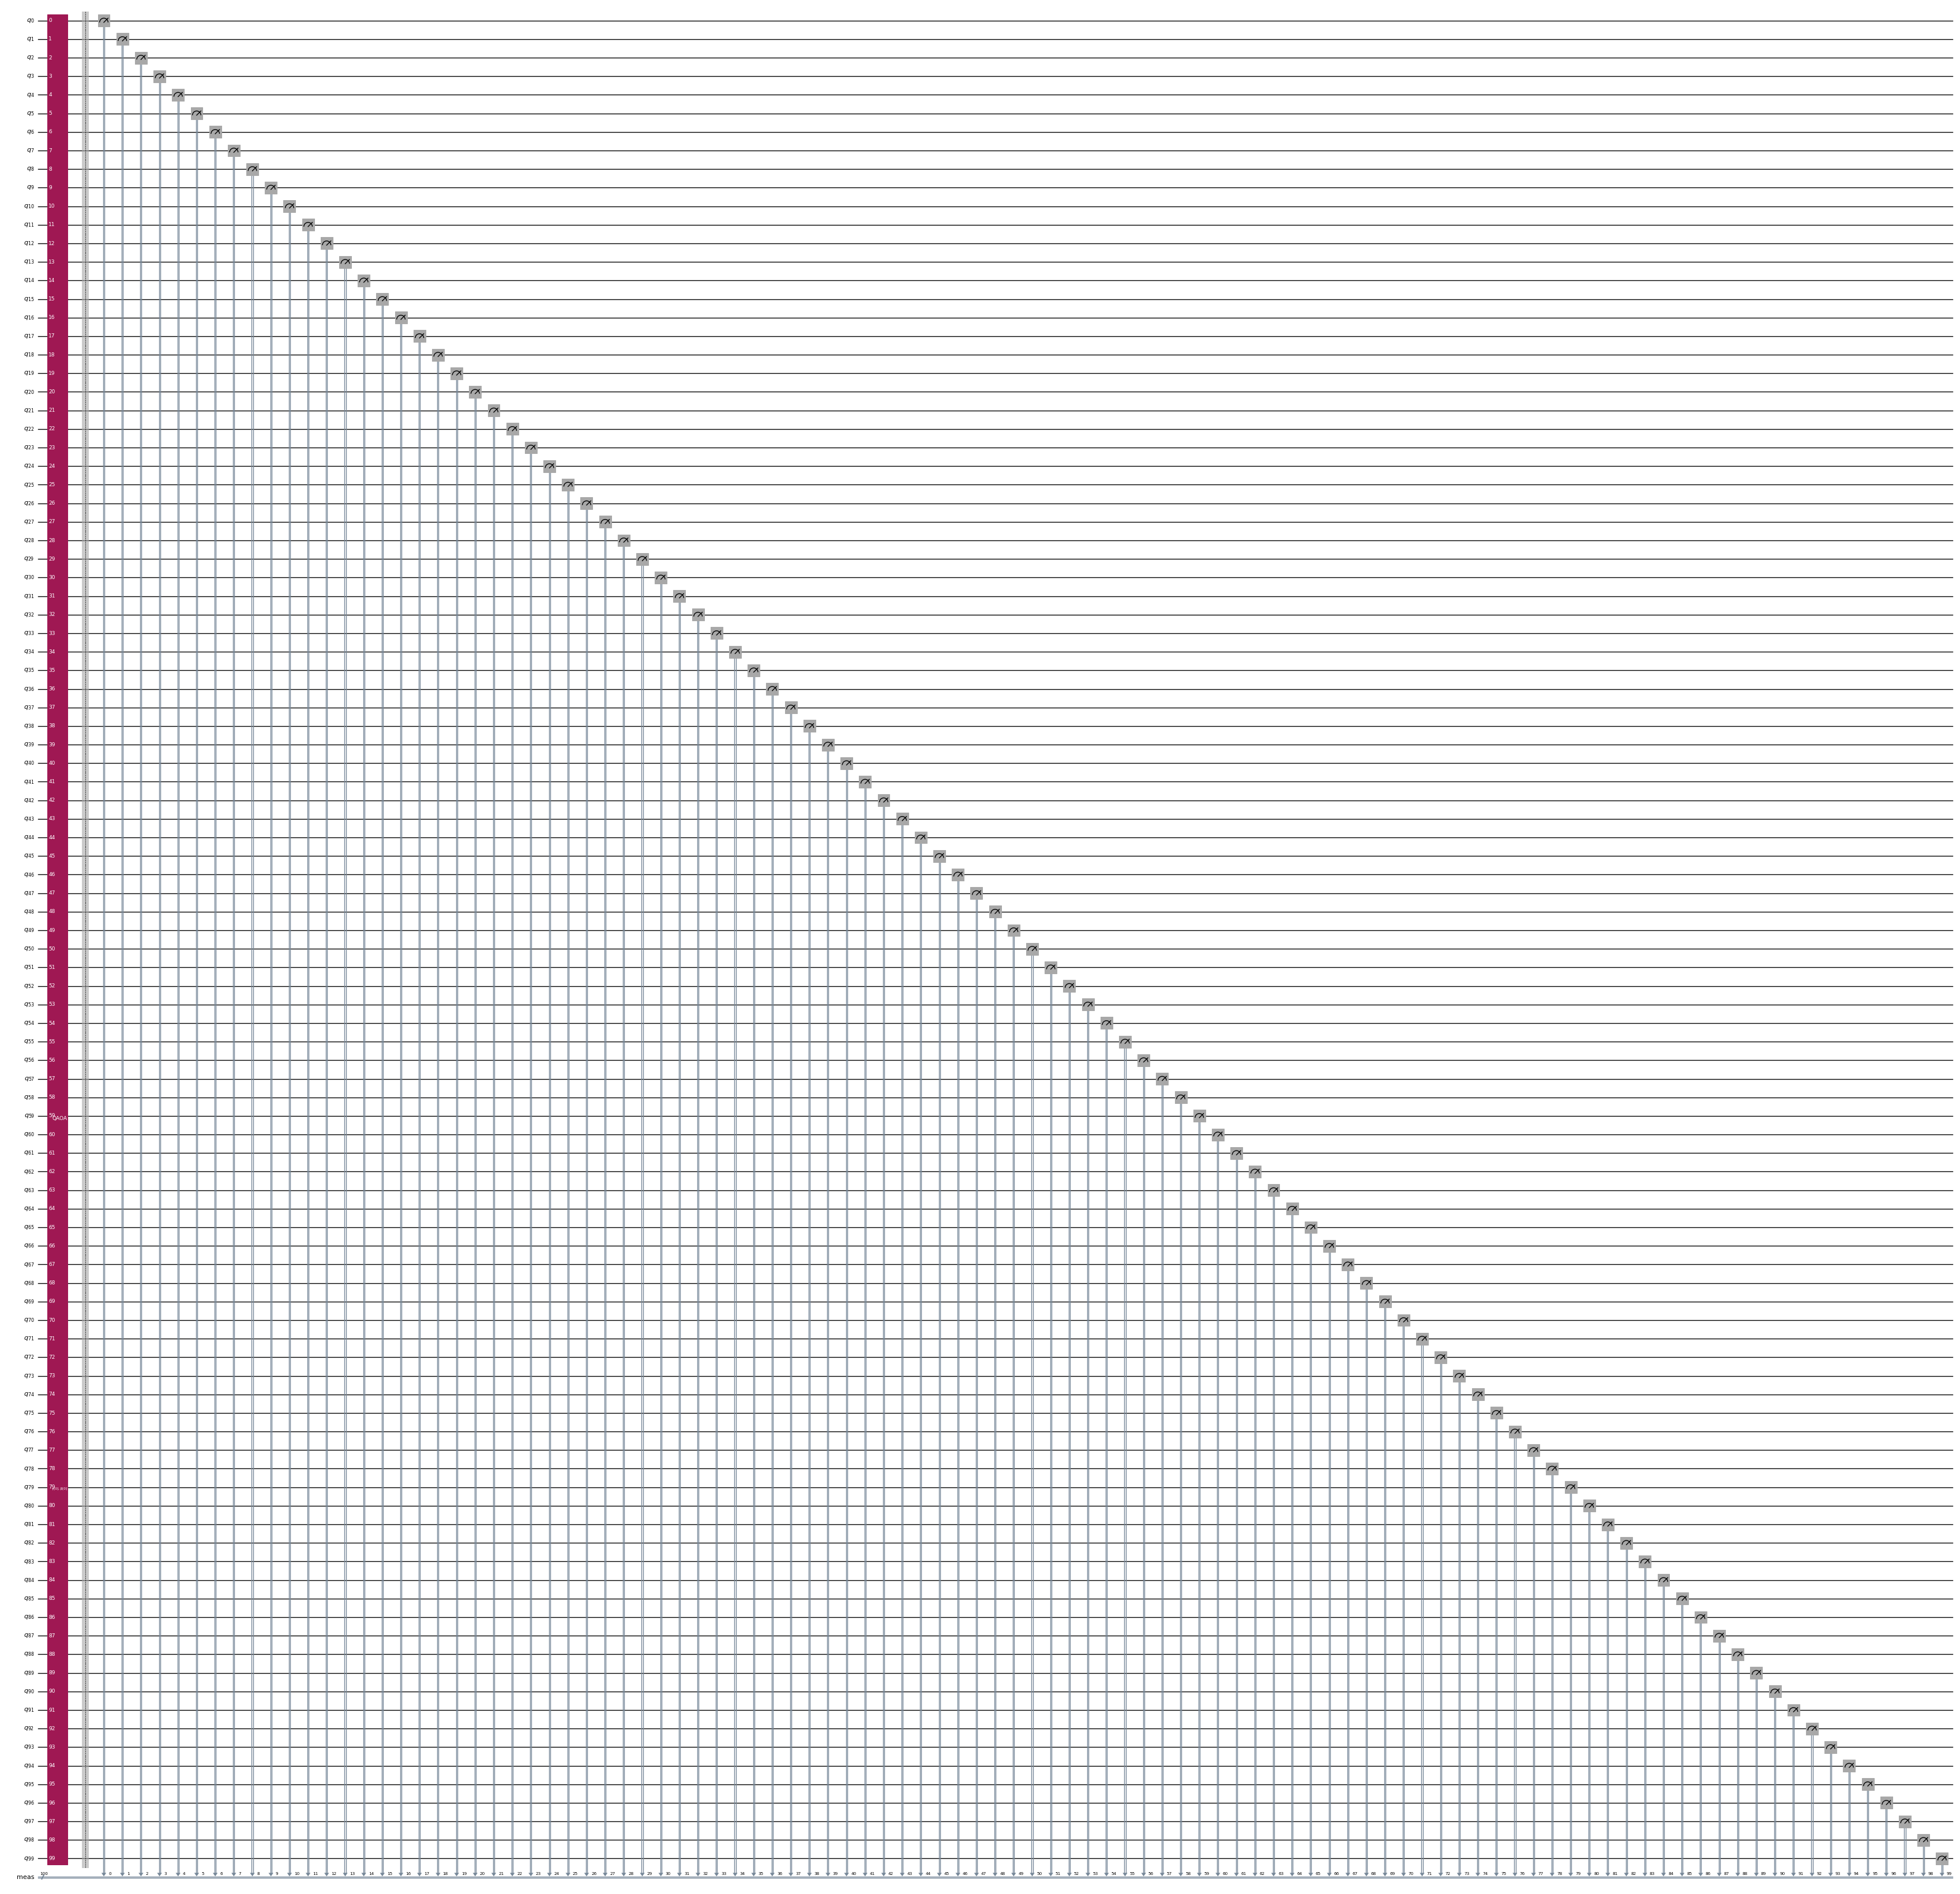

In [233]:
from qiskit.circuit.library import QAOAAnsatz

circuit = QAOAAnsatz(cost_operator= hamiltonian , reps=1)
circuit.measure_all()

circuit.draw('mpl' , fold = False , scale = 0.5 , idle_wires = False)


In [234]:
circuit.parameters

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(γ[0])])

In [235]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import SparsePauliOp


In [236]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
service = QiskitRuntimeService()
backend = service.backend("ibm_sherbrooke")
aer = AerSimulator.from_backend(backend)

#Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3 , backend=aer)
hardware_circuit = pm.run(circuit)
#hardware_circuit.draw('mpl' , fold = False , scale = 0.5 , idle_wires=False)

ValueError: Image size of 1236834x4448 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1.23683e+06x4448.11 with 1 Axes>

In [237]:
initial_gamma = 0
initial_beta = 0
init_params = [initial_gamma ,  initial_beta]

In [238]:
def cost_func_estimator(params , ansatz , hamiltonian ,  estimator):

    # transform the observable defined on virtual qubits to 
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz , isa_hamiltonian , params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)

    return cost

In [240]:
from qiskit_ibm_runtime import Session , EstimatorV2 as Estimator
from scipy.optimize import minimize

objective_func_vals = [] # Global variable

with Session(backend=aer) as session:
    # If using qiskit-ibm-runtime<0.24.0 , change 'mode=' to 'session='
    estimator = Estimator(session= session)
    estimator.options.default_shots = 1000

    # Set simple error suppresion / mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
        cost_func_estimator , 
        init_params,
        args = (hardware_circuit , hamiltonian , estimator),
        method = "COBYLA",
        
    )
    print(result)


c:\Users\isaac\anaconda3\envs\qiskit_env\Lib\site-packages\qiskit_ibm_runtime\session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(
c:\Users\isaac\anaconda3\envs\qiskit_env\Lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:243: UserWarning: Options {'default_shots': 1000, 'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")
Simulation failed and returned the following error message:
ERROR:  [Experiment 0] a circuit requires more memory than max_memory_mb.


QiskitError: 'ERROR:  [Experiment 0] a circuit requires more memory than max_memory_mb. ,  ERROR: a circuit requires more memory than max_memory_mb.'

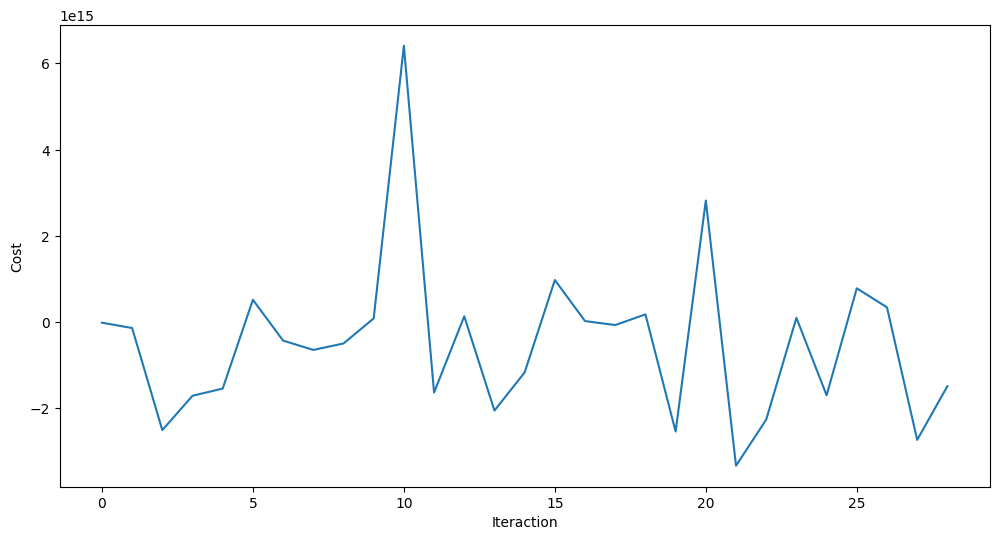

In [179]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(objective_func_vals)
plt.xlabel("Iteraction")
plt.ylabel("Cost")
plt.show()

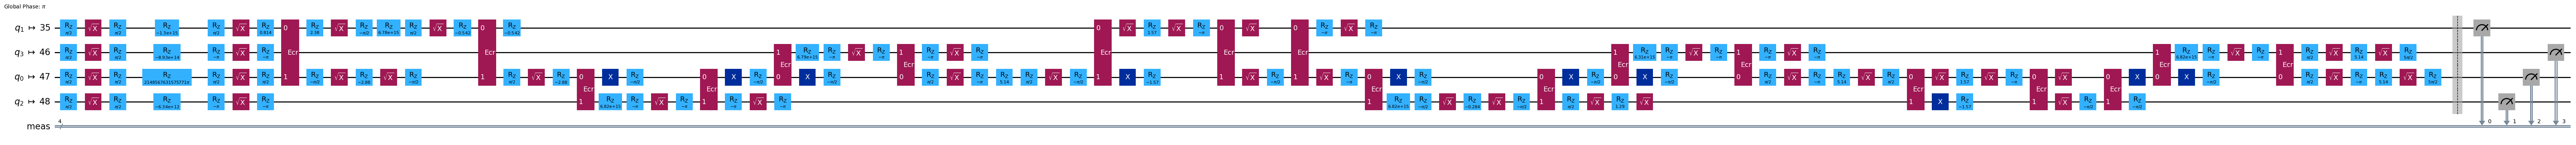

In [180]:
optimized_circuit = hardware_circuit.assign_parameters(result.x)
optimized_circuit.draw('mpl' , fold = False , idle_wires = False)

In [181]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
sampler = Sampler(backend = aer)
sampler.options.default_shots = 10000

# Set simple error suppresion/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates  = True
sampler.options.twirling.num_randomizations = "auto"

pub = (optimized_circuit , )
job = sampler.run([pub] , shots = int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()

shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)

c:\Users\isaac\anaconda3\envs\qiskit_env\Lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:243: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XY4'}, 'twirling': {'enable_gates': True, 'num_randomizations': 'auto'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


{4: 0.22, 3: 0.1792, 6: 0.0198, 10: 0.0814, 1: 0.0599, 2: 0.0623, 11: 0.0582, 8: 0.0134, 12: 0.0373, 5: 0.065, 14: 0.0583, 13: 0.0443, 0: 0.0208, 9: 0.0268, 15: 0.0422, 7: 0.0111}


In [182]:
#auxiliary function to sample most likely bitstring
def to_bitstring(interger, num_bits):
    result = np.binary_repr(interger , width = num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())

most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely , n)
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [0, 0, 1, 0]


C:\Users\isaac\AppData\Local\Temp\ipykernel_24972\2758413630.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.get_children()[int(p)].set_color("tab:purple")


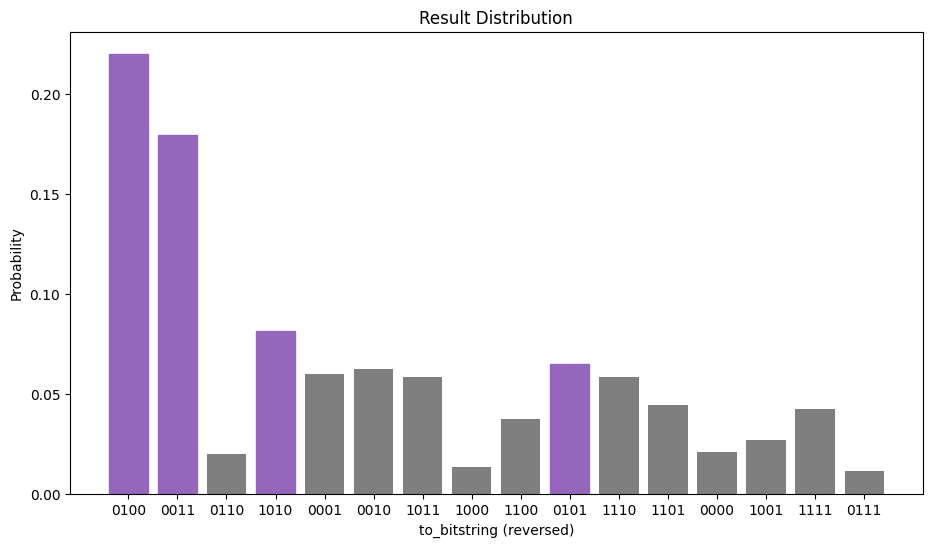

In [183]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({"font.size":10})
final_bits = final_distribution_bin
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]

positions = []

for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11 , 6))
ax = fig.add_subplot(1 , 1 , 1)
plt.title("Result Distribution")
plt.xlabel("to_bitstring (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()) , list(final_bits.values()) , color = "tab:grey")
for p in positions:
    ax.get_children()[int(p)].set_color("tab:purple")
plt.show()

In [ ]:
def d(x_list):
    d =0
    for s in range(3):
        w = 0
        for i in range(n):
            w = w + data_list_frmt[i][s]*(2*x_list[i] - 1)
        w = w/n
        w = np.abs(w)
        d = d + w
       
            
        
